In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Final Project/NewDataSet/Rice Leaf Disease detection obj.v1i.coco.zip'  # Update with your zip file's path
extracted_folder_path = '/content/extract/'  # Update with the desired extraction location

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)
    print(f"Successfully extracted the contents to {extracted_folder_path}")
except FileNotFoundError:
    print("Zip file not found. Please check the file path.")
except zipfile.BadZipFile:
    print("BAD")

Successfully extracted the contents to /content/extract/


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#F8E2CF;
           font-size:120%;
           font-family:Verdana;
           text-align:center;
           letter-spacing:0.5px">
<h1 style="padding: 25px;color:black;">FasterRCNN MobileNet v3</h1>
</div>

# Setup

In [ ]:
!pip install torch
!pip install torchvision
!pip install pycocotools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(640, 640),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(640, 640),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

class DatasetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']



        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]


            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ
    def __len__(self):
        return len(self.ids)

# Importing Dataset

In [ ]:
dataset_path = "/content/extract"
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]
classes

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


['rice-leaf-diseases',
 'Brown spot',
 'Leaf Blight',
 'Leaf Scald',
 'Leaf blast',
 'Narrow brown spot',
 'healthy']

In [ ]:
train_dataset = DatasetDetection(root=dataset_path, split='train', transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


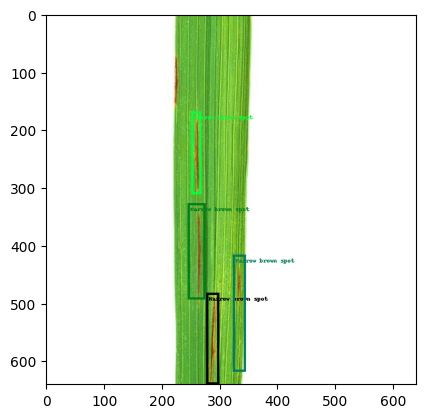

In [ ]:
sample = train_dataset[415]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

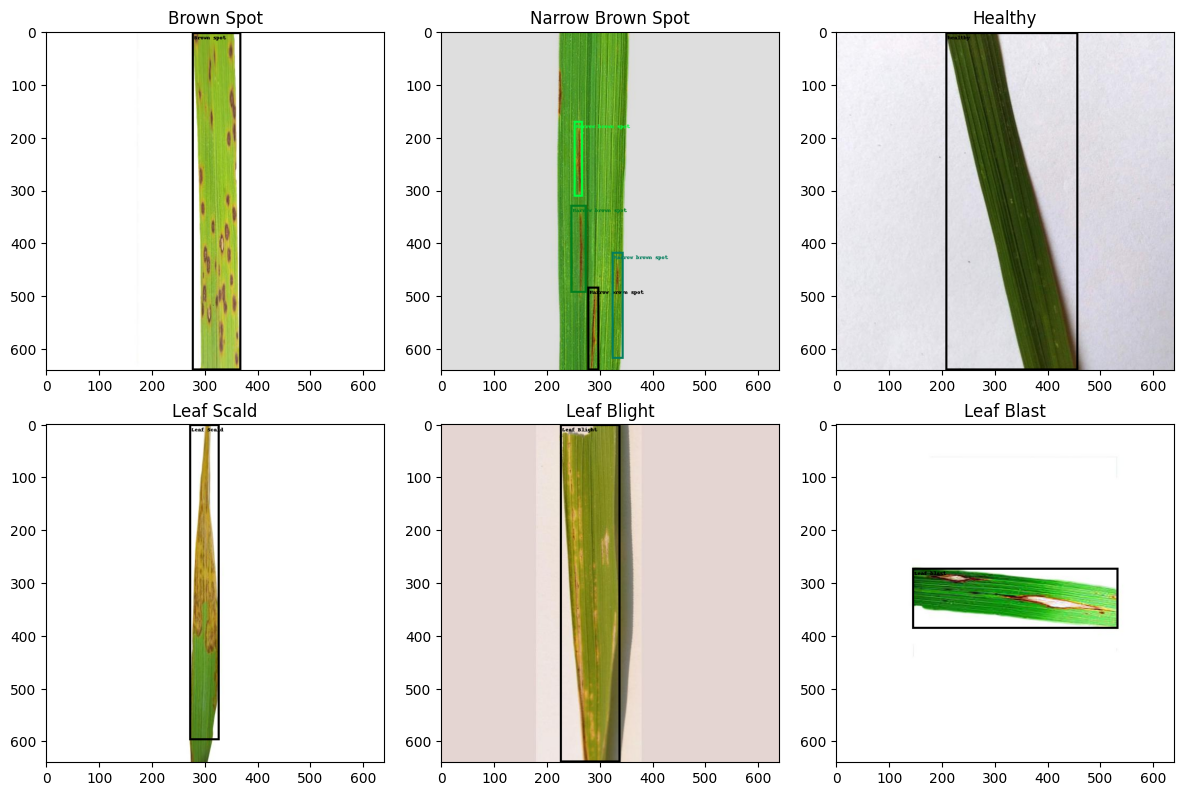

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have six samples stored in a list called samples
samples = [train_dataset[1146], train_dataset[415], train_dataset[1270], train_dataset[266], train_dataset[262], train_dataset[412]]
my_class = ["Brown Spot","Narrow Brown Spot","Healthy","Leaf Scald","Leaf Blight","Leaf Blast"]
# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Loop through each sample and plot it on the corresponding subplot
for i, sample in enumerate(samples):
    img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
    ax = axes[i // 3, i % 3]
    ax.imshow(draw_bounding_boxes(
        img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
    ).permute(1, 2, 0))
    ax.set_title(my_class[i])
    ax.axis('on')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


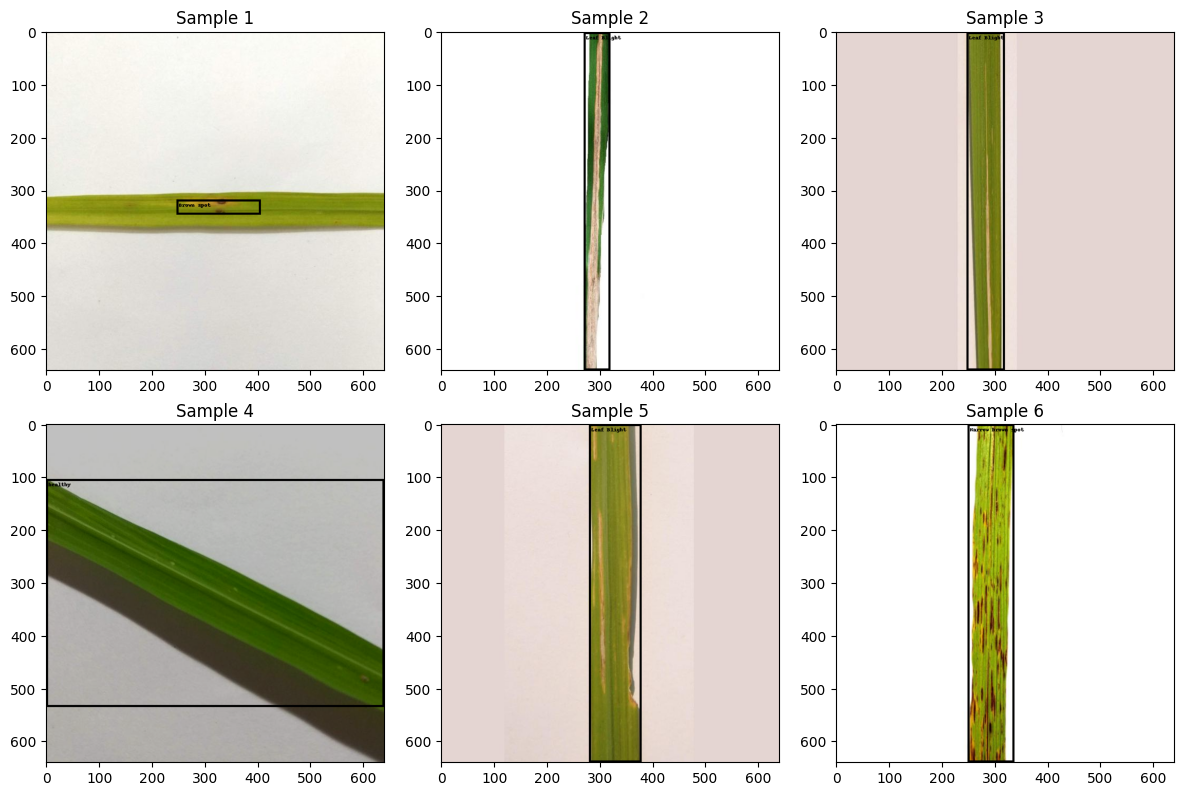

In [ ]:
samples = [train_dataset[2], train_dataset[1], train_dataset[5], train_dataset[6], train_dataset[8], train_dataset[9]]

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Loop through each sample and plot it on the corresponding subplot
for i, sample in enumerate(samples):
    img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
    ax = axes[i // 3, i % 3]
    ax.imshow(draw_bounding_boxes(
        img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
    ).permute(1, 2, 0))
    ax.set_title(f"Sample {i+1}")
    ax.axis('on')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Model

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 112MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)
device = torch.device("cuda")
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
epoch_arr = []
loss_classifier = []
loss_box_reg = []
loss_objectness = []
loss_rpn_box_reg = []

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        epoch_arr.append(epoch)
        loss_classifier.append(loss_dict_append['loss_classifier'])
        loss_box_reg.append(loss_dict_append['loss_box_reg'])
        loss_objectness.append(loss_dict_append['loss_objectness'])
        loss_rpn_box_reg.append(loss_dict_append['loss_rpn_box_reg'])

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#     history_resnet50[epoch] = all_losses_dict
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=10
history = []

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 547/547 [01:27<00:00,  6.26it/s]


Epoch 0, lr: 0.010000, loss: 0.373814, loss_classifier: 0.150512, loss_box: 0.113069, loss_rpn_box: 0.052500, loss_object: 0.057734


100%|██████████| 547/547 [01:15<00:00,  7.29it/s]


Epoch 1, lr: 0.010000, loss: 0.323930, loss_classifier: 0.132726, loss_box: 0.113721, loss_rpn_box: 0.039992, loss_object: 0.037490


100%|██████████| 547/547 [01:12<00:00,  7.57it/s]


Epoch 2, lr: 0.010000, loss: 0.310965, loss_classifier: 0.125905, loss_box: 0.115296, loss_rpn_box: 0.036371, loss_object: 0.033393


100%|██████████| 547/547 [01:11<00:00,  7.65it/s]


Epoch 3, lr: 0.010000, loss: 0.303346, loss_classifier: 0.123927, loss_box: 0.117336, loss_rpn_box: 0.034141, loss_object: 0.027942


100%|██████████| 547/547 [01:10<00:00,  7.72it/s]


Epoch 4, lr: 0.010000, loss: 0.303283, loss_classifier: 0.124230, loss_box: 0.121575, loss_rpn_box: 0.031970, loss_object: 0.025508


100%|██████████| 547/547 [01:11<00:00,  7.63it/s]


Epoch 5, lr: 0.010000, loss: 0.307683, loss_classifier: 0.127002, loss_box: 0.122160, loss_rpn_box: 0.031400, loss_object: 0.027120


100%|██████████| 547/547 [01:12<00:00,  7.57it/s]


Epoch 6, lr: 0.010000, loss: 0.308630, loss_classifier: 0.126103, loss_box: 0.126610, loss_rpn_box: 0.030832, loss_object: 0.025085


100%|██████████| 547/547 [01:09<00:00,  7.92it/s]


Epoch 7, lr: 0.010000, loss: 0.305817, loss_classifier: 0.125860, loss_box: 0.127946, loss_rpn_box: 0.029032, loss_object: 0.022979


100%|██████████| 547/547 [01:08<00:00,  7.93it/s]


Epoch 8, lr: 0.010000, loss: 0.317440, loss_classifier: 0.131101, loss_box: 0.135829, loss_rpn_box: 0.027968, loss_object: 0.022543


100%|██████████| 547/547 [01:08<00:00,  7.95it/s]

Epoch 9, lr: 0.010000, loss: 0.314357, loss_classifier: 0.129088, loss_box: 0.134188, loss_rpn_box: 0.028386, loss_object: 0.022694


In [ ]:
history = pd.DataFrame()
history["epoch"] = epoch_arr
history["loss_classifier"] = loss_classifier
history["loss_box_reg"] = loss_box_reg
history["loss_objectness"] = loss_objectness
history["loss_rpn_box_reg"] = loss_rpn_box_reg

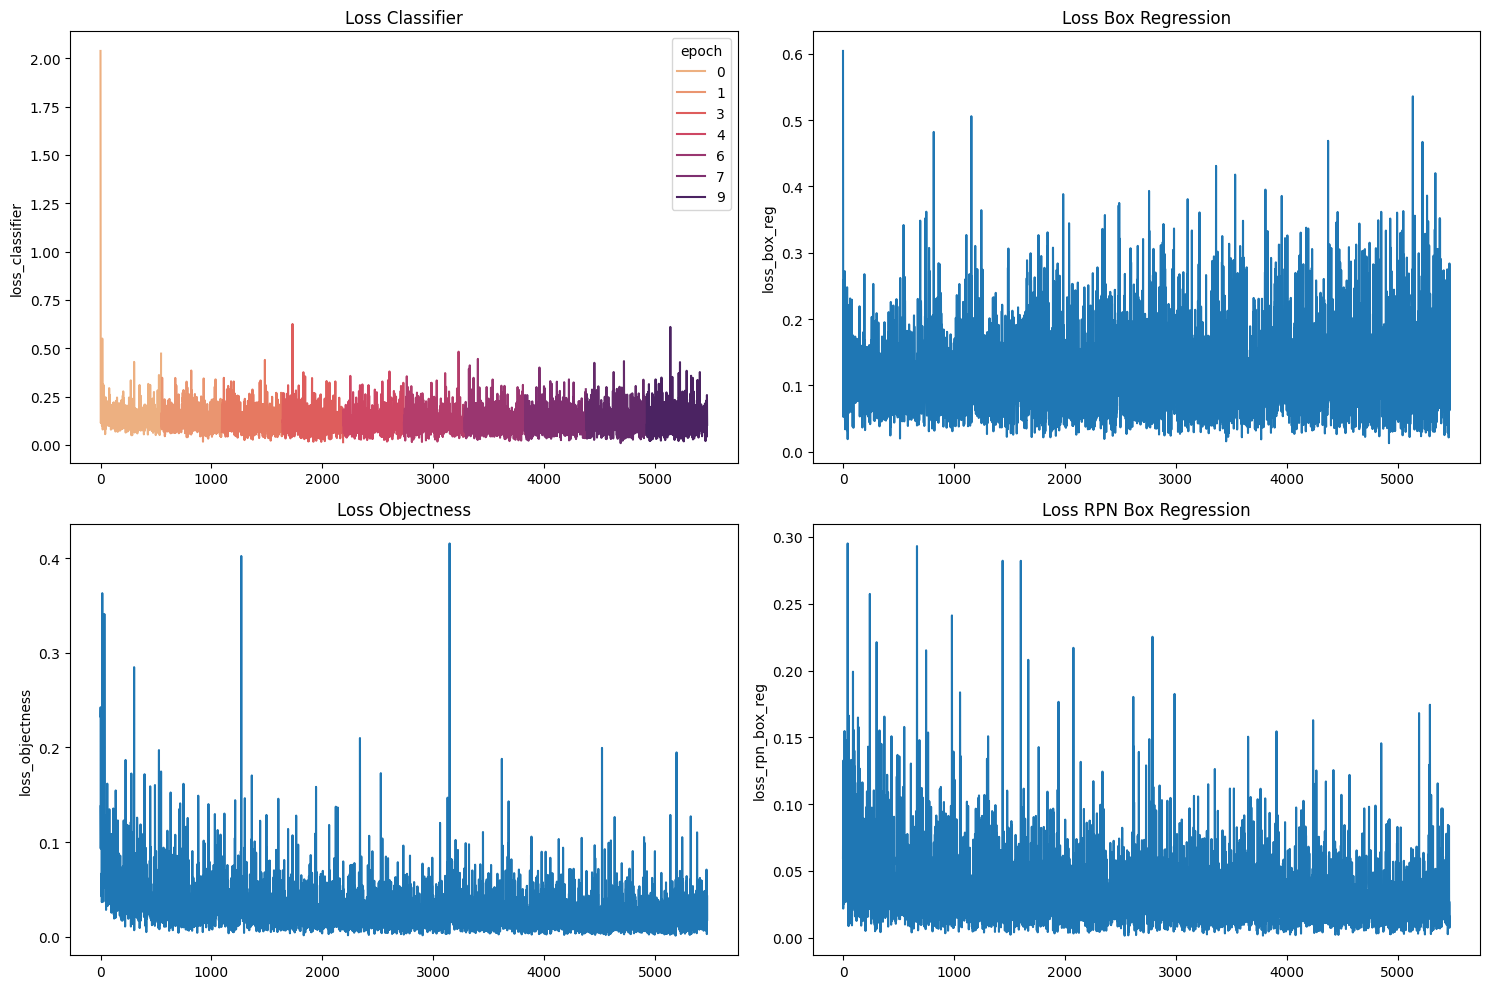

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First subplot
sns.lineplot(data=history, x=history.index, y="loss_classifier", palette="flare", errorbar=None, hue="epoch", ax=axes[0, 0])
axes[0, 0].set_title("Loss Classifier")

# Second subplot
sns.lineplot(data=history, x=history.index, y="loss_box_reg", palette="flare", errorbar=None, ax=axes[0, 1])
axes[0, 1].set_title("Loss Box Regression")

# Third subplot
sns.lineplot(data=history, x=history.index, y="loss_objectness", palette="flare", errorbar=None, ax=axes[1, 0])
axes[1, 0].set_title("Loss Objectness")

# Fourth subplot
sns.lineplot(data=history, x=history.index, y="loss_rpn_box_reg", palette="flare", errorbar=None, ax=axes[1, 1])
axes[1, 1].set_title("Loss RPN Box Regression")

fig.tight_layout()
plt.show()


In [ ]:
torch.save(model,"finale_frcnn-mobilenetv3.pt")

In [ ]:
loadedModel = torch.load("finale_frcnn-mobilenetv3.pt")

In [ ]:
loadedModel.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = DatasetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


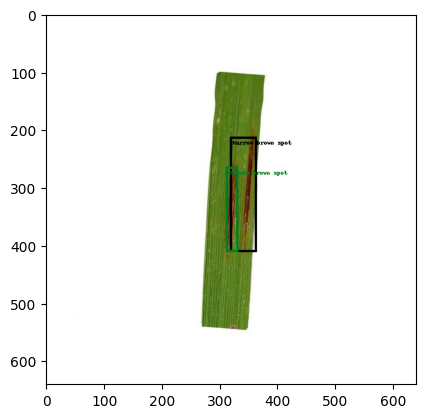

In [ ]:
sample = test_dataset[12]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

{'boxes': tensor([[309.7990, 252.0382, 325.9114, 410.6194],
        [343.2316, 187.1173, 362.1237, 366.6664],
        [310.9797, 252.1405, 343.4458, 418.0482],
        [335.5994, 183.9974, 367.9180, 396.5971],
        [310.3837, 264.3673, 317.6407, 399.8369],
        [333.9421, 188.4191, 354.7288, 372.5804]], device='cuda:0'), 'labels': tensor([5, 5, 5, 5, 5, 5], device='cuda:0'), 'scores': tensor([0.6765, 0.5150, 0.4753, 0.2169, 0.1879, 0.0828], device='cuda:0')}


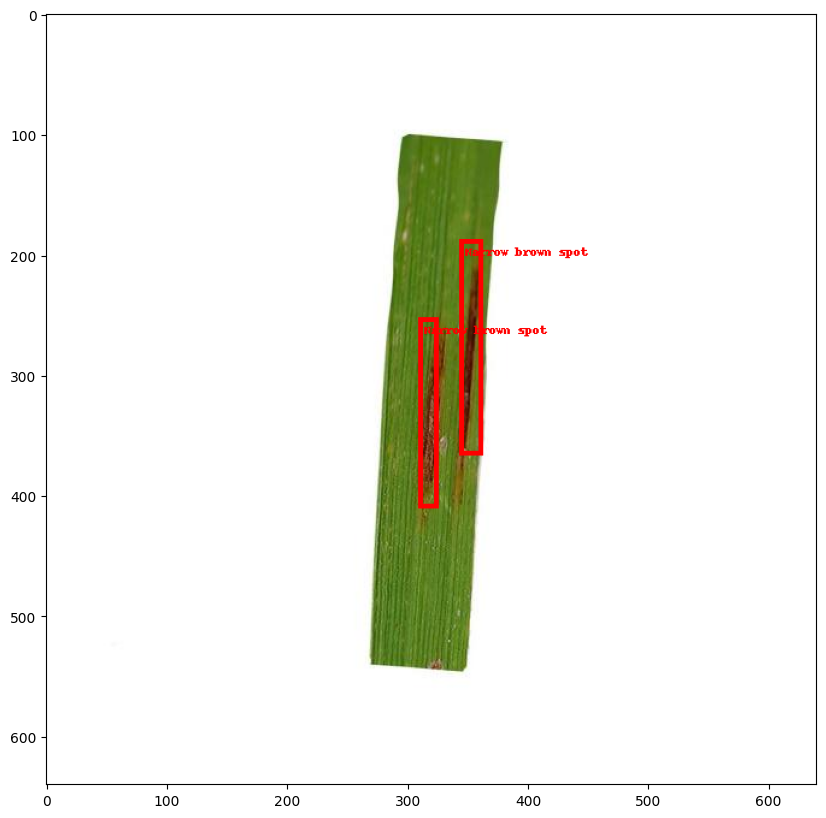

In [ ]:
img, _ = test_dataset[12]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = loadedModel([img.to(device)])
    pred = prediction[0]
    print(pred)

fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#F8E2CF;
           font-size:120%;
           font-family:Verdana;
           text-align:center;
           letter-spacing:0.5px">
<h1 style="padding: 25px;color:black;">FasterRCNN ResNet50</h1>
</div>

In [ ]:
# lets load the faster rcnn model
# model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 46.8MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)
device = torch.device("cuda")
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
epoch_arr = []
loss_classifier = []
loss_box_reg = []
loss_objectness = []
loss_rpn_box_reg = []

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        epoch_arr.append(epoch)
        loss_classifier.append(loss_dict_append['loss_classifier'])
        loss_box_reg.append(loss_dict_append['loss_box_reg'])
        loss_objectness.append(loss_dict_append['loss_objectness'])
        loss_rpn_box_reg.append(loss_dict_append['loss_rpn_box_reg'])

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#     history_resnet50[epoch] = all_losses_dict
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 410/410 [05:19<00:00,  1.28it/s]


Epoch 0, lr: 0.010000, loss: 0.364420, loss_classifier: 0.118611, loss_box: 0.102157, loss_rpn_box: 0.085267, loss_object: 0.058384


100%|██████████| 410/410 [05:19<00:00,  1.29it/s]


Epoch 1, lr: 0.010000, loss: 0.289763, loss_classifier: 0.093200, loss_box: 0.095601, loss_rpn_box: 0.067772, loss_object: 0.033189


100%|██████████| 410/410 [05:19<00:00,  1.28it/s]


Epoch 2, lr: 0.010000, loss: 0.278090, loss_classifier: 0.089573, loss_box: 0.094954, loss_rpn_box: 0.062458, loss_object: 0.031105


100%|██████████| 410/410 [05:18<00:00,  1.29it/s]


Epoch 3, lr: 0.010000, loss: 0.272862, loss_classifier: 0.087445, loss_box: 0.098460, loss_rpn_box: 0.059434, loss_object: 0.027523


100%|██████████| 410/410 [05:18<00:00,  1.29it/s]


Epoch 4, lr: 0.010000, loss: 0.261405, loss_classifier: 0.081413, loss_box: 0.098325, loss_rpn_box: 0.055606, loss_object: 0.026061


100%|██████████| 410/410 [05:17<00:00,  1.29it/s]


Epoch 5, lr: 0.010000, loss: 0.254371, loss_classifier: 0.077788, loss_box: 0.097541, loss_rpn_box: 0.054100, loss_object: 0.024942


100%|██████████| 410/410 [05:18<00:00,  1.29it/s]


Epoch 6, lr: 0.010000, loss: 0.248414, loss_classifier: 0.075964, loss_box: 0.096768, loss_rpn_box: 0.051766, loss_object: 0.023915


100%|██████████| 410/410 [05:18<00:00,  1.29it/s]


Epoch 7, lr: 0.010000, loss: 0.248947, loss_classifier: 0.075496, loss_box: 0.098187, loss_rpn_box: 0.051545, loss_object: 0.023719


100%|██████████| 410/410 [05:18<00:00,  1.29it/s]


Epoch 8, lr: 0.010000, loss: 0.243256, loss_classifier: 0.075023, loss_box: 0.096327, loss_rpn_box: 0.049366, loss_object: 0.022540


100%|██████████| 410/410 [05:18<00:00,  1.29it/s]

Epoch 9, lr: 0.010000, loss: 0.236980, loss_classifier: 0.071926, loss_box: 0.094565, loss_rpn_box: 0.048470, loss_object: 0.022019


In [ ]:
torch.save(model,"finale_frcnn-restnet50.pt")

In [ ]:
history_resnet50 = pd.DataFrame()
history_resnet50["epoch"] = epoch_arr
history_resnet50["loss_classifier"] = loss_classifier
history_resnet50["loss_box_reg"] = loss_box_reg
history_resnet50["loss_objectness"] = loss_objectness
history_resnet50["loss_rpn_box_reg"] = loss_rpn_box_reg

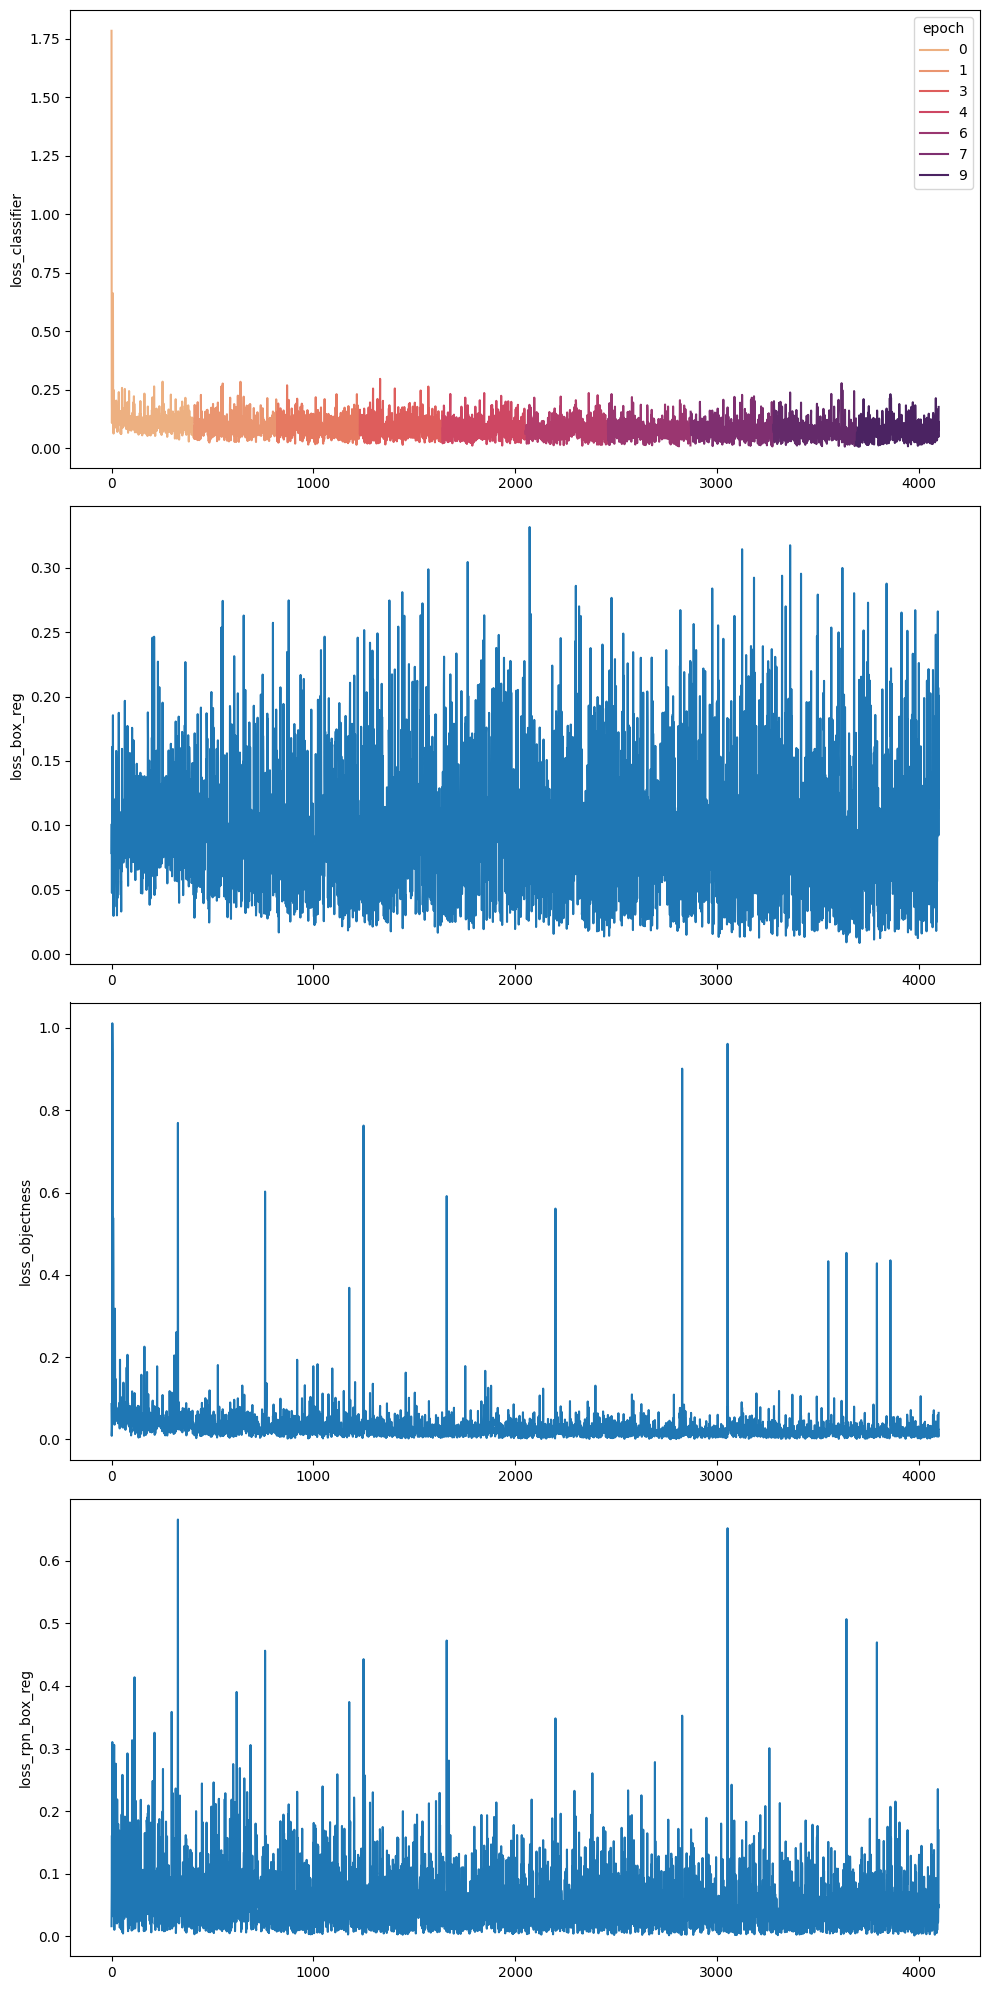

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(4,1,figsize=(10, 20))

plt.subplot(4,1,1)
sns.lineplot(data=history_resnet50,x=history_resnet50.index,y="loss_classifier",palette="flare",errorbar = None,hue="epoch");

plt.subplot(4,1,2)
sns.lineplot(history_resnet50["loss_box_reg"],palette="flare",errorbar = None);

plt.subplot(4,1,3)
sns.lineplot(history_resnet50["loss_objectness"],palette="flare",errorbar = None);

plt.subplot(4,1,4)
sns.lineplot(history_resnet50["loss_rpn_box_reg"],palette="flare",errorbar = None);

fig.tight_layout()
plt.show()

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = DatasetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


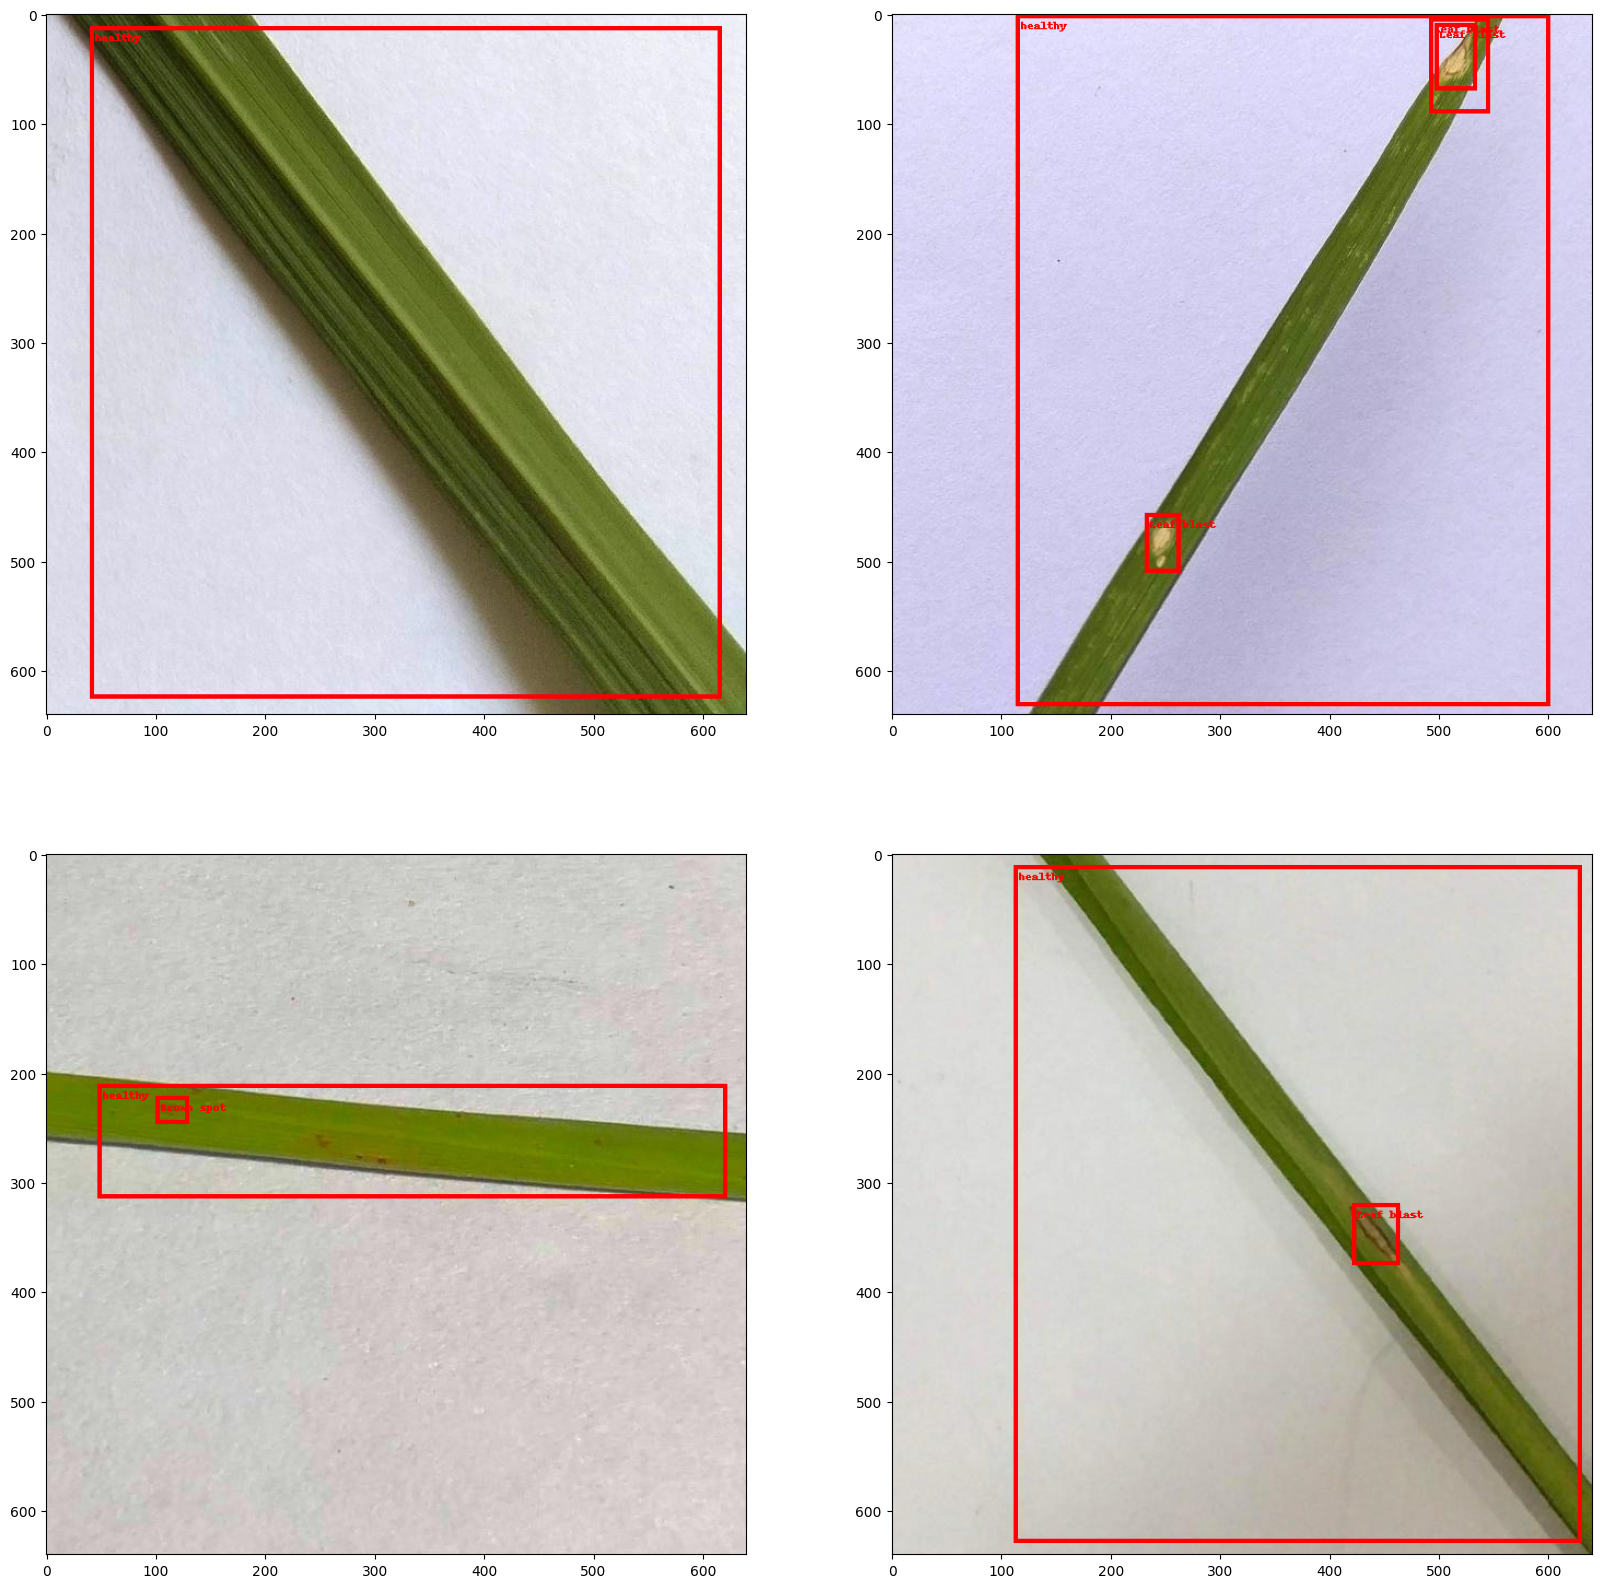

In [ ]:
import random

fig, axes = plt.subplots(2,2,figsize=(20, 20))


img, _ = test_dataset[random.randint(1, 100)]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

plt.subplot(2,2,1)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

img, _ = test_dataset[random.randint(1, 100)]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

plt.subplot(2,2,2)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

img, _ = test_dataset[random.randint(1, 100)]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

plt.subplot(2,2,3)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

img, _ = test_dataset[random.randint(1, 100)]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

plt.subplot(2,2,4)
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))

In [ ]:
!cp "/content/finale_frcnn-mobilenetv3.pt" "/content/drive/MyDrive/"

In [ ]:
!cp "/content/finale_frcnn-restnet50.pt" "/content/drive/MyDrive/"